# ehrMGAN: Electronic Health Records Multiple Generative Adversarial Networks
This notebook implements the complete ehrMGAN model for generating synthetic electronic health records data. The model combines VAEs and GANs to generate both continuous (vital signs) and discrete (medications/interventions) time series data.

## 1. Environment Setup
First, let's set up our environment with the necessary imports and check the configuration.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import timeit
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create directories if they don't exist
os.makedirs("data/checkpoint/", exist_ok=True)
os.makedirs("data/fake/", exist_ok=True)
os.makedirs("logs/", exist_ok=True)

# Environment information
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages

TensorFlow version: 1.14.0
NumPy version: 1.19.5
Pandas version: 1.1.5


In [2]:
import platform
import psutil
import GPUtil

# System info
print(f"System: {platform.system()} {platform.version()}")
print(f"Python version: {platform.python_version()}")
print(f"Processor: {platform.processor()}")

# Memory info
memory = psutil.virtual_memory()
print(f"Total memory: {memory.total / (1024**3):.2f} GB")
print(f"Available memory: {memory.available / (1024**3):.2f} GB")

# GPU info
try:
    gpus = GPUtil.getGPUs()
    if gpus:
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu.name}, Memory: {gpu.memoryTotal} MB")
            print(f"   Memory used: {gpu.memoryUsed} MB, Load: {gpu.load*100:.1f}%")
    else:
        print("No GPU detected")
except:
    print("Could not detect GPU information")

# Check if TensorFlow sees GPUs
print("\nTensorFlow GPU availability:")
print(f"GPU available: {tf.test.is_gpu_available()}")

System: Windows 10.0.19041
Python version: 3.6.15
Processor: AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
Total memory: 31.93 GB
Available memory: 22.66 GB
GPU 0: NVIDIA GeForce RTX 3060, Memory: 12288.0 MB
   Memory used: 836.0 MB, Load: 3.0%

TensorFlow GPU availability:
GPU available: False


### 2. Import Model Components
Now let's import the necessary model components from our files.

In [3]:
# Import the model components
import sys
sys.path.append('.')

# Let's first import the necessary modules
from networks import C_VAE_NET, D_VAE_NET, C_GAN_NET, D_GAN_NET
from m3gan import m3gan
from utils import renormlizer
from visualise import visualise_gan, visualise_vae

### 3. Data Loading and Preprocessing
Let's load and preprocess the data.

In [4]:
# Data parameters
patinet_num = 16062
filename_postfix = '5_var'

# Load continuous data (vital signs)
continuous_x = np.loadtxt(f'data/real/mimic/vital_sign_24hrs_{filename_postfix}_mimiciv.txt')
continuous_x = continuous_x.reshape(patinet_num, 24, 5)
print(f"Continuous data shape: {continuous_x.shape}")

# Load discrete data (medications/interventions)
discrete_x = np.loadtxt(f'data/real/mimic/med_interv_24hrs_{filename_postfix}_mimiciv.txt')
discrete_x = discrete_x.reshape(patinet_num, 24, 1)
print(f"Discrete data shape: {discrete_x.shape}")

# Load static data (patient demographics)
statics_label = pd.read_csv(f'data/real/mimic/static_data_{filename_postfix}_mimiciv.csv')
statics_label = np.asarray(statics_label)[:, 0].reshape([-1, 1])
print(f"Static labels shape: {statics_label.shape}")

# Data statistics
print("\nContinuous data statistics:")
print(f"Mean: {np.mean(continuous_x, axis=(0,1))}")
print(f"Std: {np.std(continuous_x, axis=(0,1))}")
print(f"Min: {np.min(continuous_x, axis=(0,1))}")
print(f"Max: {np.max(continuous_x, axis=(0,1))}")

print("\nDiscrete data statistics:")
print(f"Mean: {np.mean(discrete_x)}")
print(f"Std: {np.std(discrete_x)}")
print(f"Min: {np.min(discrete_x)}")
print(f"Max: {np.max(discrete_x)}")

# Optional: Use a subset for faster experimentation
use_subset = False
subset_size = 5000
if use_subset:
    indices = np.random.choice(continuous_x.shape[0], subset_size, replace=False)
    continuous_x = continuous_x[indices]
    discrete_x = discrete_x[indices]
    statics_label = statics_label[indices]
    print(f"\nUsing subset of data: {subset_size} samples")

Continuous data shape: (16062, 24, 5)
Discrete data shape: (16062, 24, 1)
Static labels shape: (16062, 1)

Continuous data statistics:
Mean: [0.39582974 0.64002727 0.95716821 0.33487669 0.39307435]
Std: [0.07905853 0.17579326 0.05761428 0.18632828 0.12541822]
Min: [0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1.]

Discrete data statistics:
Mean: 0.5533661229402731
Std: 0.4971438996129025
Min: 0.0
Max: 1.0


### 4. Model Configuration and Hyperparameter Tuning
Let's define our hyperparameters based on the data dimensions.

In [5]:
# Configure hyperparameters based on data dimensions
time_steps = continuous_x.shape[1]  # 24 hours
c_dim = continuous_x.shape[2]       # 5 continuous features
d_dim = discrete_x.shape[2]         # 1 discrete feature
num_samples = continuous_x.shape[0] # Number of patients

# Latent space dimensions
# For complex data with higher dimensions, we need a larger latent space
shared_latent_dim = 15 
c_z_size = shared_latent_dim
c_noise_dim = max(2, int(c_dim/2))  # At least 2 dimensions
d_z_size = shared_latent_dim
d_noise_dim = max(1, int(d_dim/2))  # At least 1 dimension

# Network sizes - scale based on data complexity
batch_size = 1024  # Can be adjusted based on memory constraints
enc_dec_size = 128  # For 5 features, 128 is reasonable
enc_dec_layers = 2  # For 24 time steps, 2-3 layers is reasonable
gen_units = 256     # For generation quality
gen_layers = 2
disc_units = 128
disc_layers = 2
dropout_keep = 0.8  # 0.8 is typically good for medical data

# Learning rates - typically smaller for stable training
v_lr_pre = 0.005   # VAE pretraining
v_lr = 0.001       # VAE fine-tuning
g_lr = 0.001       # Generator
d_lr = 0.001       # Discriminator

# Training parameters
use_subset = True
if use_subset:
    num_pre_epochs = 36
    num_epochs = 60
else:
    num_pre_epochs = 300  # For 16K patients, 300 pre-epochs should be sufficient
    num_epochs = 500      # For GAN stability, 500 epochs should work well
d_rounds = 1          # Standard practice
g_rounds = 3          # Multiple generator updates per discriminator update
v_rounds = 1          # VAE updates

# Loss weights
alpha_re = 1.0    # Reconstruction weight (primary objective)
alpha_kl = 0.5    # KL divergence weight
alpha_mt = 0.2    # Matching weight (increased for better coordination)
alpha_ct = 0.2    # Contrastive weight (increased for feature learning)
alpha_sm = 1.0    # Semantic weight

# GAN loss weights
c_beta_adv = 1.0   # Adversarial weight for continuous
c_beta_fm = 10.0   # Feature matching for continuous (reduced to prevent mode collapse)
d_beta_adv = 1.0   # Adversarial weight for discrete
d_beta_fm = 10.0   # Feature matching for discrete (reduced for stability)

# Regularization
l2_scale = 0.001   # L2 regularization

# Conditional GAN parameters
conditional = False  # Whether to use conditional GAN
num_labels = 1 if conditional else 0  # Number of conditional labels

# Display configuration
print("Model Configuration:")
print(f"Latent dimensions - Continuous: {c_z_size}, Discrete: {d_z_size}")
print(f"Noise dimensions - Continuous: {c_noise_dim}, Discrete: {d_noise_dim}")
print(f"Batch size: {batch_size}")
print(f"Pre-training epochs: {num_pre_epochs}, Training epochs: {num_epochs}")
print(f"Network sizes - Encoder/Decoder: {enc_dec_size}, Generator: {gen_units}, Discriminator: {disc_units}")
print(f"Network layers - Encoder/Decoder: {enc_dec_layers}, Generator: {gen_layers}, Discriminator: {disc_layers}")
print(f"Learning rates - VAE pre: {v_lr_pre}, VAE: {v_lr}, Generator: {g_lr}, Discriminator: {d_lr}")

Model Configuration:
Latent dimensions - Continuous: 15, Discrete: 15
Noise dimensions - Continuous: 2, Discrete: 1
Batch size: 1024
Pre-training epochs: 36, Training epochs: 60
Network sizes - Encoder/Decoder: 128, Generator: 256, Discriminator: 128
Network layers - Encoder/Decoder: 2, Generator: 2, Discriminator: 2
Learning rates - VAE pre: 0.005, VAE: 0.001, Generator: 0.001, Discriminator: 0.001


### 5. Build Model Components
Now let's build the model components.

In [6]:
# For TF1.x compatibility
tf.reset_default_graph()

# Define the VAE and GAN networks
c_vae = C_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=c_dim,
    z_dim=c_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

c_gan = C_GAN_NET(
    batch_size=batch_size,
    noise_dim=c_noise_dim,
    dim=c_dim,
    gen_dim=c_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_vae = D_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=d_dim,
    z_dim=d_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_gan = D_GAN_NET(
    batch_size=batch_size,
    noise_dim=d_noise_dim,
    dim=d_dim,
    gen_dim=d_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

### 6. Create and Train the Model
Now let's set up the complete model and train it.

In [7]:
# Define checkpoint directory
checkpoint_dir = "data/checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

# REPLACE the model building section (cell #6) with this:
# Reset the TensorFlow graph to avoid variable conflicts
tf.reset_default_graph()
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth = True
sess = tf.Session(config=run_config)

# Create the complete M3GAN model
model = m3gan(
    sess=sess,
    batch_size=batch_size,
    time_steps=time_steps,
    num_pre_epochs=num_pre_epochs,
    num_epochs=num_epochs,
    checkpoint_dir=checkpoint_dir,
    epoch_ckpt_freq=100,  # Save checkpoint every 100 epochs
    epoch_loss_freq=1,   # Display loss every 10 epochs
    
    # Continuous parameters
    c_dim=c_dim,
    c_noise_dim=c_noise_dim,
    c_z_size=c_z_size,
    c_data_sample=continuous_x,
    c_vae=c_vae,
    c_gan=c_gan,
    
    # Discrete parameters
    d_dim=d_dim,
    d_noise_dim=d_noise_dim,
    d_z_size=d_z_size,
    d_data_sample=discrete_x,
    d_vae=d_vae,
    d_gan=d_gan,
    
    # Training parameters
    d_rounds=d_rounds,
    g_rounds=g_rounds,
    v_rounds=v_rounds,
    v_lr_pre=v_lr_pre,
    v_lr=v_lr,
    g_lr=g_lr,
    d_lr=d_lr,
    
    # Loss weights
    alpha_re=alpha_re,
    alpha_kl=alpha_kl,
    alpha_mt=alpha_mt,
    alpha_ct=alpha_ct,
    alpha_sm=alpha_sm,
    c_beta_adv=c_beta_adv,
    c_beta_fm=c_beta_fm,
    d_beta_adv=d_beta_adv,
    d_beta_fm=d_beta_fm,
    
    # Conditional parameters
    conditional=conditional,
    num_labels=num_labels,
    statics_label=statics_label
)

# Build the model
print("Building the model...")
model.build()

W0226 21:49:29.476910  7792 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:118: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0226 21:49:29.479913  7792 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:106: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0226 21:49:29.479913  7792 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:106: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0226 21:49:29.484918  7792 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:115: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.Sta

Building the model...


W0226 21:49:29.524829  7792 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:147: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0226 21:49:29.559512  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:29.575136  7792 deprecation.py:506] From c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is 

W0226 21:49:29.637642  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 21:49:29.668894  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:29.693401  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:29.771972  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:29.810938  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 21:49:29.844708  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 21:49:29.875220  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:29.906472  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:29.942662  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:29.975920  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:30.011039  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:30.042291  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:30.061233  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:30.093499  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:30.157143  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:30.178047  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:30.227485  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 21:49:30.258738  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:30.261257  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:30.361407  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 21:49:30.393406  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:30.409034  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:30.577974  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:30.578360  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:30.611297  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:30.644153  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:30.755080  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 21:49:30.786332  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:30.794843  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:30.941426  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:30.978231  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 21:49:30.993855  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:31.011290  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 21:49:31.157044  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 21:49:31.193800  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:31.209427  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:31.338039  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:31.361584  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:31.408463  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:31.427995  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:31.544750  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:31.575902  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:31.610175  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:31.643759  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:31.724009  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:31.760643  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:31.791896  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:31.807522  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:31.991431  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:32.028591  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:32.191538  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:32.207165  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:32.409401  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:32.427995  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:32.575924  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210AAB199B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:32.594698  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:32.766585  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:32.782212  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934ADA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:32.957031  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:32.988284  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934A668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:33.168600  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109934A198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:33.199852  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109934AA20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:33.355051  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E6EB550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E6EB550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:33.378395  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:33.686576  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:33.702202  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:33.894222  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:33.911327  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109CE57128>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:34.083214  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E6EB550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E6EB550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:34.111227  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:34.294898  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:34.326149  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 21:49:34.473795  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109CE57128>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109CE57128>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:34.510445  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E6EB550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:34.673887  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:34.694442  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:34.851064  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:34.878623  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:35.035217  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109CE57128>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109CE57128>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:35.061515  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E6EB550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:35.238315  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:35.238315  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:35.612078  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:35.627702  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109CE57128>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:35.828158  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:35.843783  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:35.987401  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:36.011939  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:36.183163  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:36.198790  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109CE57128>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:36.368481  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E6EB550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E6EB550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:36.392425  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:36.551831  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:36.593439  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:36.760308  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E606550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:36.775933  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109CE57128>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:36.970559  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:36.994715  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:37.150976  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A112AB70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A112AB70>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:37.182229  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:37.375751  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A13F37B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A13F37B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:37.391377  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:37.538249  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:37.560093  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A18D1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:37.811025  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:37.827758  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A1824908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:38.033029  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:38.045524  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A18D1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:38.186159  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A18D1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A18D1630>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:38.227837  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A112AB70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:38.393690  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:38.393690  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A1824908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:38.599907  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:38.615533  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A18D1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:38.814289  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:38.829916  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A1824908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:39.017270  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:39.032896  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A18D1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:39.201040  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A112AB70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A112AB70>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:39.232293  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:39.394417  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A1824908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A1824908>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:39.426660  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A13F37B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:39.593273  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:39.611193  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A18D1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:39.811003  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:39.825771  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A1824908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 21:49:39.995804  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A13F37B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A13F37B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:40.026817  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 21:49:40.159270  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:40.175945  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A18D1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:40.459284  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:40.478206  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A1824908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:40.679185  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A14DFE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:40.692648  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A18D1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:40.875963  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A112AB70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A112AB70>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:40.909318  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A18ADEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:41.059301  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A0060710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A0060710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:41.092324  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:41.242661  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:41.275978  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:41.440783  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A3E36F28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A3E36F28>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:41.442674  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A457CC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:41.661993  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:41.691608  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:41.830758  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:41.858272  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A3E36F28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:42.059342  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:42.078331  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:42.242645  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:42.274861  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A3E36F28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:42.430754  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A457CC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A457CC50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:42.460976  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A0060710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:42.627738  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:42.644397  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:42.842853  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:42.863254  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A3E36F28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:43.045250  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A0060710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A0060710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:43.075879  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 21:49:43.226752  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 21:49:43.492964  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:43.559575  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 21:49:43.693295  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:43.709274  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:43.892602  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A3E36F28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A3E36F28>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:43.908955  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A457CC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:44.109969  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:44.125757  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:44.292605  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:44.331161  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A3E36F28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:44.442601  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:44.476748  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A3E36F28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:44.663291  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A0060710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A0060710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:44.694790  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:44.959194  7792 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:476: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0226 21:49:44.975915  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021101CFAAC8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021101CFAAC8>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 21:49:45.196240  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021101D99358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021101D99358>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:45.242680  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021101E33E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110


W0226 21:49:45.442635  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021101E93EB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021101E93EB8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:45.475897  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021102549320>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000211

W0226 21:49:45.612652  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000211023C75F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000211023C75F8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:45.659374  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110289E828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110

W0226 21:49:45.827730  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110289E828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110289E828>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:45.861131  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021102A49D30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110

W0226 21:49:46.039734  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021102AE95C0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021102AE95C0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:46.075858  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021102B9CEB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110

W0226 21:49:46.261986  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021102EF3940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021102EF3940>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:46.292937  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021102F70E80>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110

W0226 21:49:46.475902  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000211031456D8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000211031456D8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:46.526726  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021102A83EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110


W0226 21:49:46.692586  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021103185C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021103185C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:46.742628  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021104425E80>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000211

W0226 21:49:46.876040  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110454D9E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110454D9E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:46.935723  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000021104733D68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110

W0226 21:49:47.392753  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110449CF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110449CF98>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:47.442694  7792 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000211045BD390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002110


W0226 21:49:47.592568  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:47.633725  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:47.759245  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:47.792258  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:47.963515  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:47.992567  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso


W0226 21:49:48.142603  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:48.176060  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:48.332705  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000210A2709940>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:48.342588  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:48.542565  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:48.575896  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 21:49:48.745080  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:48.775916  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 21:49:48.942647  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A49D6CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:48.975904  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A118B438>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:49.159216  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:49.175578  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:49.375873  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:49.394809  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:49.540702  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:49.563645  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:49.742561  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:49.763245  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:49.927688  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002109E590860>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:49.942252  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:50.142550  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:50.175895  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 21:49:50.342574  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:50.375917  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 21:49:50.542685  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:50.575887  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 21:49:50.742537  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E66F278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:50.776025  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002109E566080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:50.942485  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:50.942485  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107333E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:51.147039  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:51.159220  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107333E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:51.609226  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110720B550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110720B550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:51.639105  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:51.825697  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110720B550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110720B550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:51.842664  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 21:49:51.992547  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:51.992547  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107333E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:52.175869  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110720B550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110720B550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:52.196888  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:52.414094  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:52.430694  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107333E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:52.559174  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107333E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107333E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:52.592559  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110720B550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:52.742553  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110720B550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110720B550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:52.763575  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211073FB4A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:52.942525  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:52.962245  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021101B9EFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:53.133640  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:53.142503  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:53.342522  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:53.363705  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021101B9EFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 21:49:53.542503  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:53.563167  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021101B9EFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:53.729635  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:53.742665  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:53.929652  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:53.942506  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:54.146765  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:54.159174  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021101B9EFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:54.324780  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:54.347201  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211071B5D68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:54.509142  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000021107247F60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:54.546418  7792 ag_logging.py:145] Entity <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x0000021101CE4E48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Flatten.call of <tensorflow.python.layers.co

W0226 21:49:54.709160  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:54.763329  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A4506C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:54.909159  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A4506C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A4506C18>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:54.939803  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:55.147225  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:55.159180  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:55.295198  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:55.332667  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A4506C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:55.474785  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A4506C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A4506C18>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:55.497495  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 21:49:55.711864  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:55.726644  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 21:49:55.866649  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:55.892535  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000210A4506C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 21:49:56.059155  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:56.075830  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:56.609176  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002110933F9B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:56.634037  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110785A4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:56.809152  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110C6B5B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110C6B5B70>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:56.842731  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000211060D1320>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:56.992462  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:57.014117  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110C6B5B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:57.208831  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:57.209167  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110C6B5B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 21:49:57.425489  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110C6B5B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110C6B5B70>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:57.444895  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000211060D1320>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 21:49:57.609153  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:57.609153  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110C6B5B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:57.809140  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:57.827520  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110C6B5B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:58.013823  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:58.029619  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002110C6B5B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 21:49:58.192461  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000211060D1320>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000211060D1320>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:58.214605  7792 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000211076AD198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 21:49:58.392461  7792 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000211060D1320>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000211060D1320>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 21:49:58.415313  7792 ag_logging.py:145] Entity <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x000002110C70ACC0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Flatten.call of <tensorflow.python.layers.co

W0226 21:49:58.598502  7792 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\Contrastivelosslayer.py:26: The name tf.losses.softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.softmax_cross_entropy instead.

W0226 21:49:58.909145  7792 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:371: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0226 21:51:02.875231  7792 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:406: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0226 21:51:02.875231  7792 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:414: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0226 21:51:02.891864  7792 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:478: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWrit

Initializing or restoring model...
Restoring model from checkpoint: data/checkpoint/final_model


W0226 21:51:03.342539  7792 deprecation.py:323] From c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Starting training...
start pretraining
pretraining epoch 0
pretraining epoch 000: loss_cvae: 105.685 | loss_dvae: 74.625 | loss_matching: 1.030 | loss_contra: 358.528 
pretraining epoch 000: loss_cvae: 102.472 | loss_dvae: 40.181 | loss_matching: 0.602 | loss_contra: 157.484 
pretraining epoch 000: loss_cvae: 91.770 | loss_dvae: 35.450 | loss_matching: 0.512 | loss_contra: 128.003 
pretraining epoch 000: loss_cvae: 68.513 | loss_dvae: 40.471 | loss_matching: 0.557 | loss_contra: 153.426 
pretraining epoch 000: loss_cvae: 109.156 | loss_dvae: 109.069 | loss_matching: 1.401 | loss_contra: 499.887 
pretraining epoch 000: loss_cvae: 56.687 | loss_dvae: 52.251 | loss_matching: 0.715 | loss_contra: 219.874 
pretraining epoch 000: loss_cvae: 55.047 | loss_dvae: 44.606 | loss_matching: 0.632 | loss_contra: 183.774 
pretraining epoch 000: loss_cvae: 54.510 | loss_dvae: 39.836 | loss_matching: 0.578 | loss_contra: 161.346 
pretraining epoch 000: loss_cvae: 55.216 | loss_dvae: 37.483 | loss_match

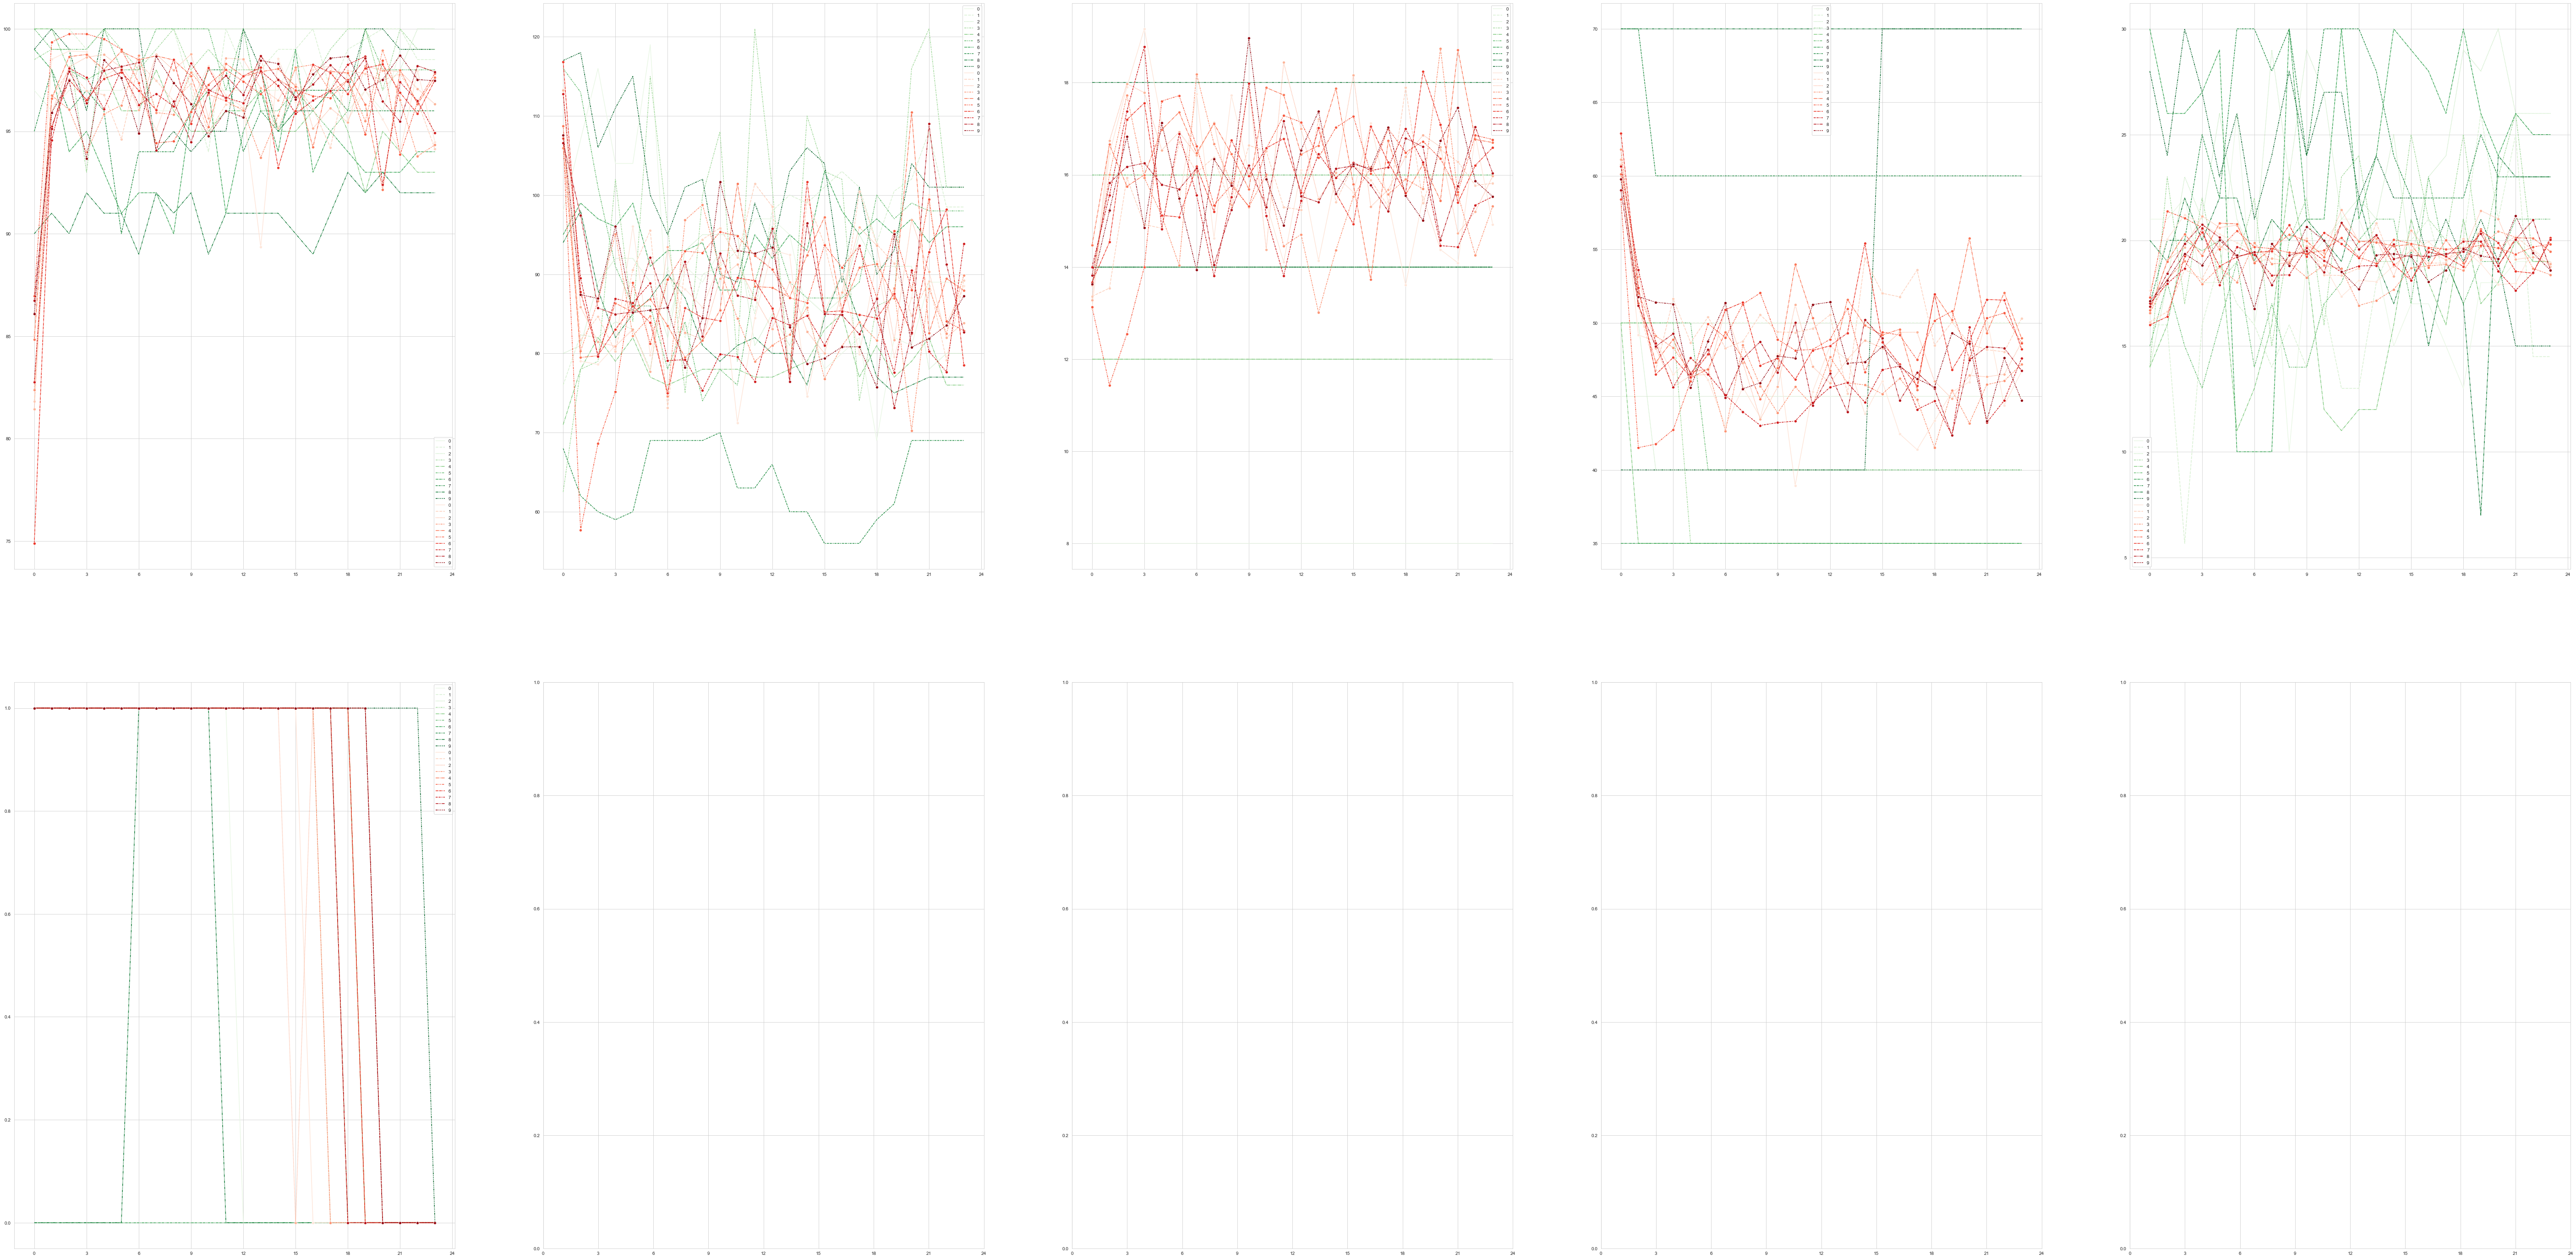

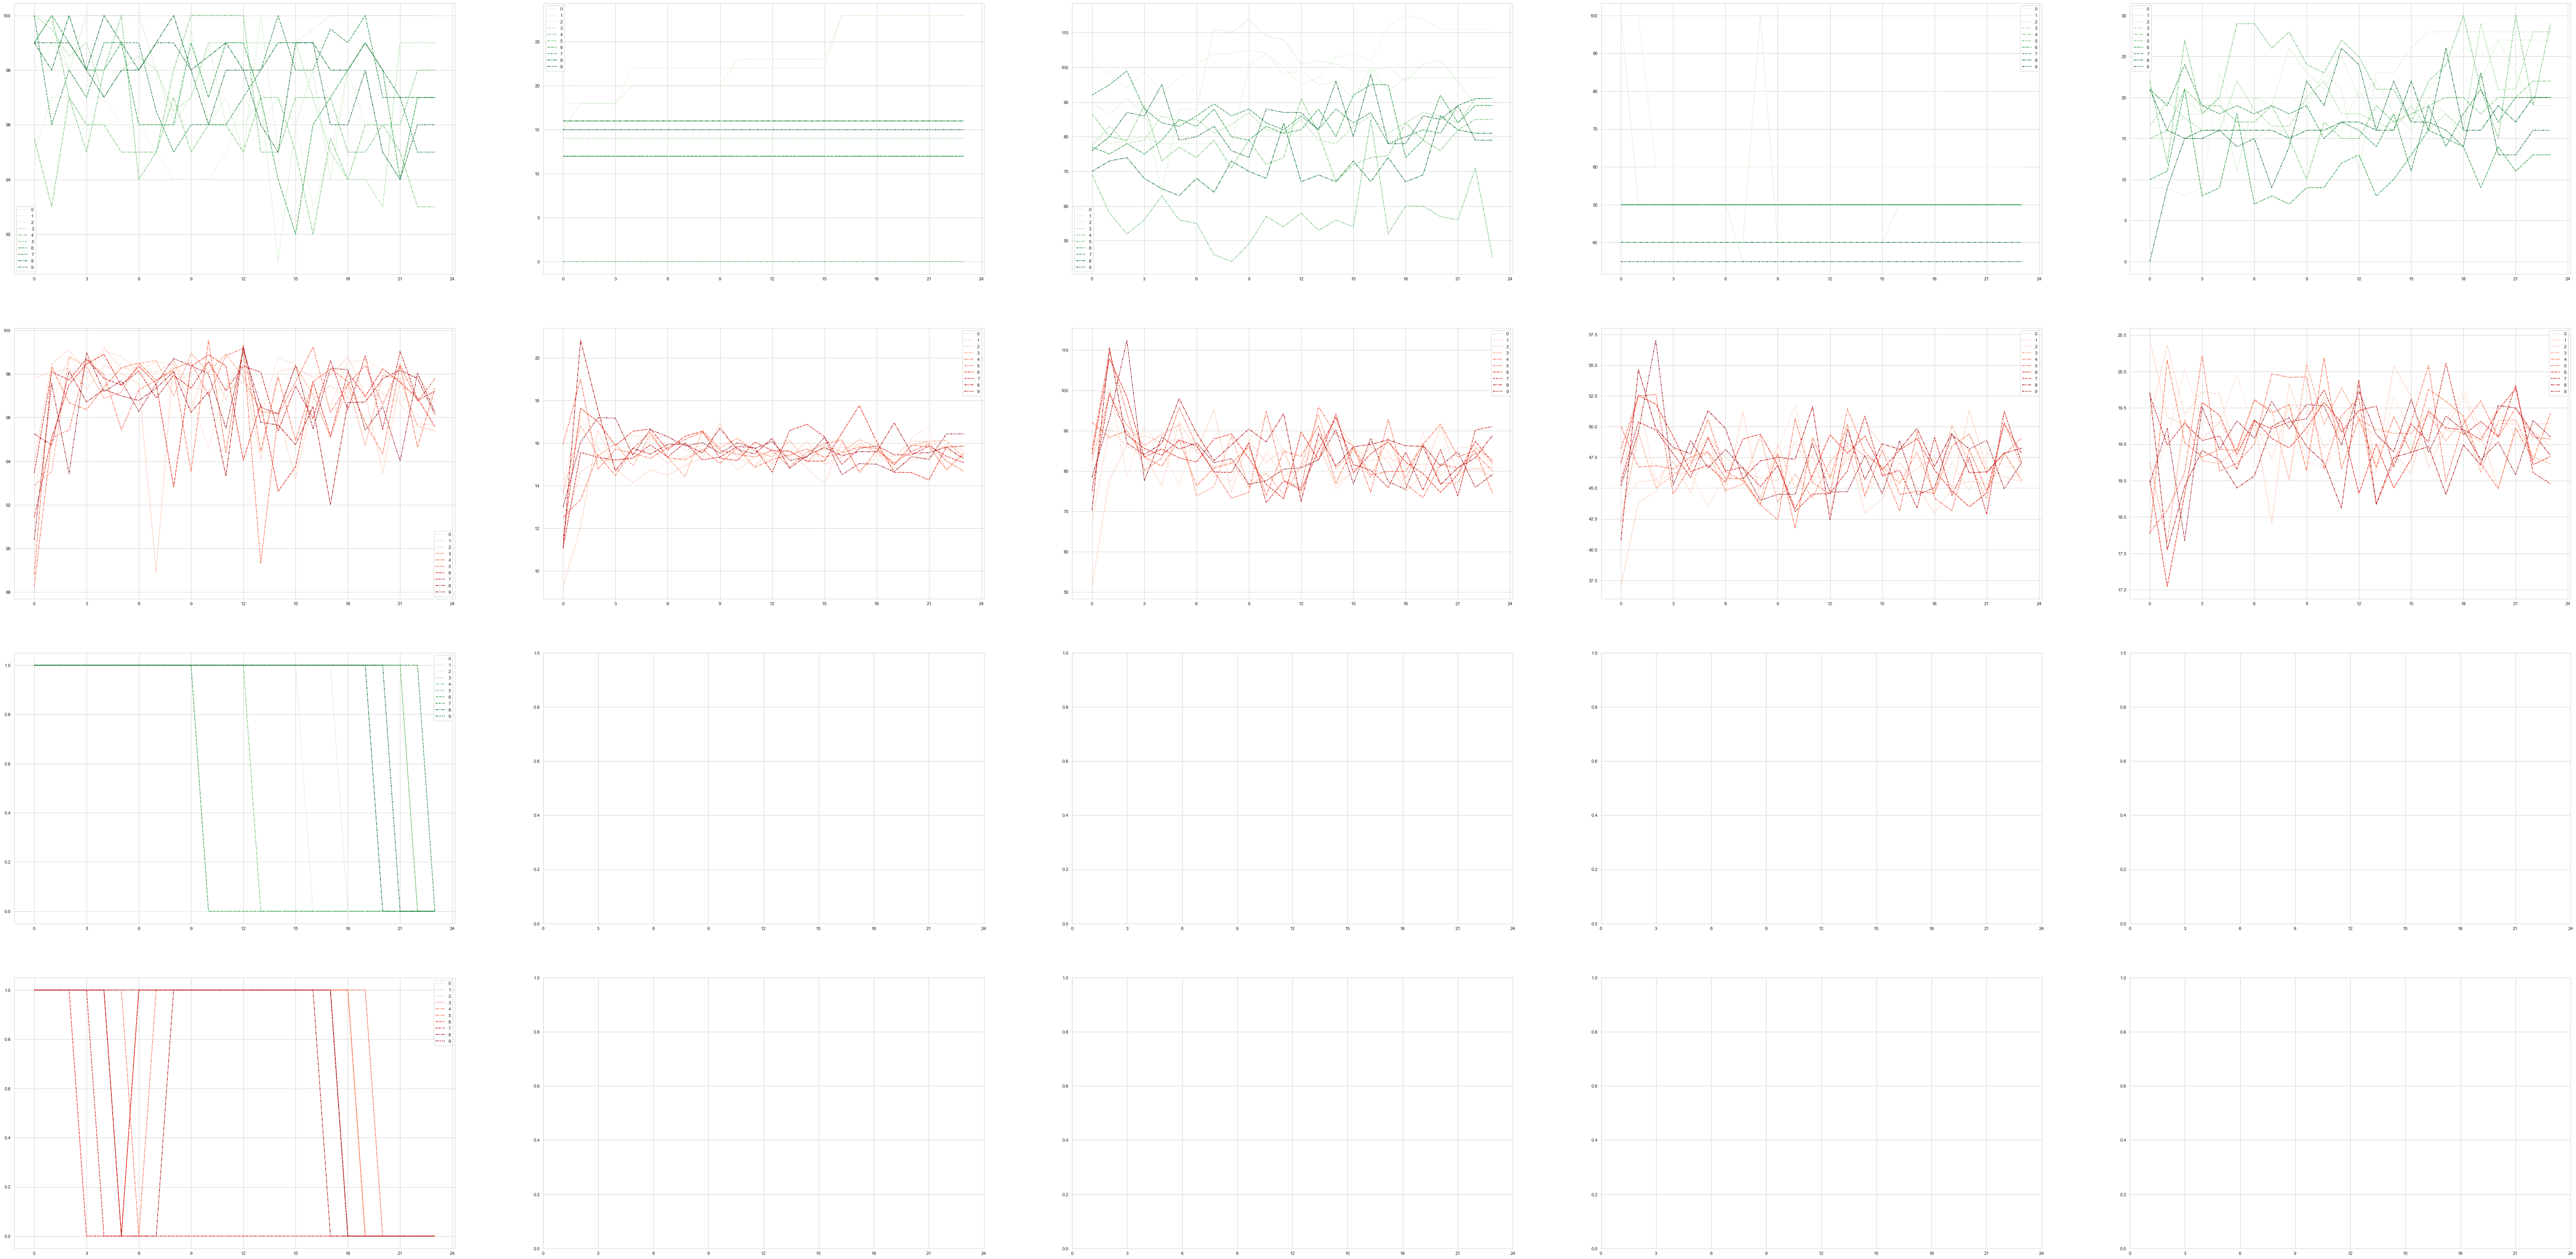

In [8]:
# REPLACE the training section (cell #8) with:
# Initialize variables or restore from checkpoint
print("Initializing or restoring model...")
checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if checkpoint:
    print(f"Restoring model from checkpoint: {checkpoint}")
    # Only create the saver after the model is built
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint)
else:
    print("No checkpoint found, initializing variables")
    sess.run(tf.global_variables_initializer())

# Train the model
print("Starting training...")
start_time = timeit.default_timer()

# Only run this cell for training - you can comment it out to skip training
train_model = True
if train_model:
    model.train()
    # Save the final model - create saver only if needed to avoid variable conflicts
    if 'saver' not in locals():
        saver = tf.train.Saver()
    save_path = os.path.join(checkpoint_dir, "final_model")
    saver.save(sess, save_path)
    print(f"Model saved to {save_path}")

end_time = timeit.default_timer()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

### 7.2 Addressing First Hour Low Variance Issue
Let's analyze and fix the issue with low standard deviation in the first hour.

Generating synthetic data...
Renormalizing generated data...
Analyzing variance across time steps...


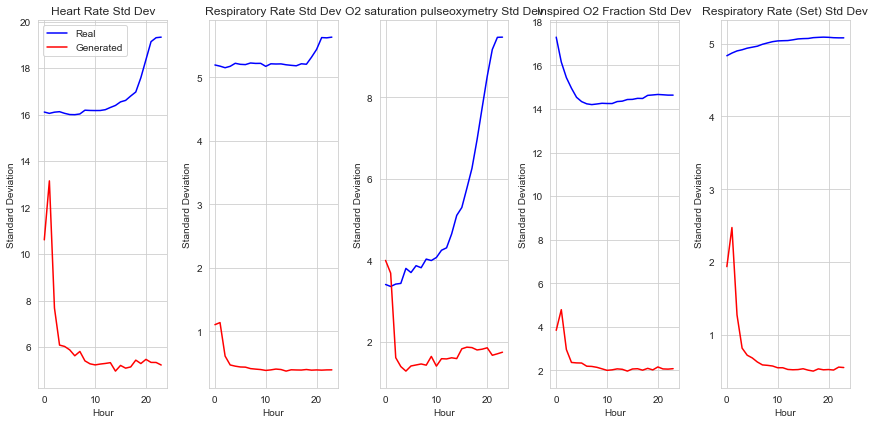


Applying variance correction to the first hour...

Applying enhanced variance correction to the first hour...


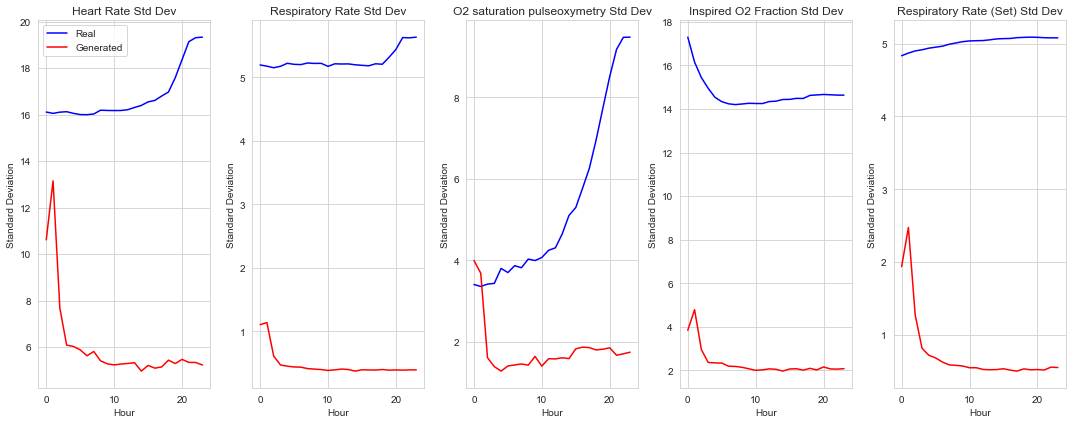

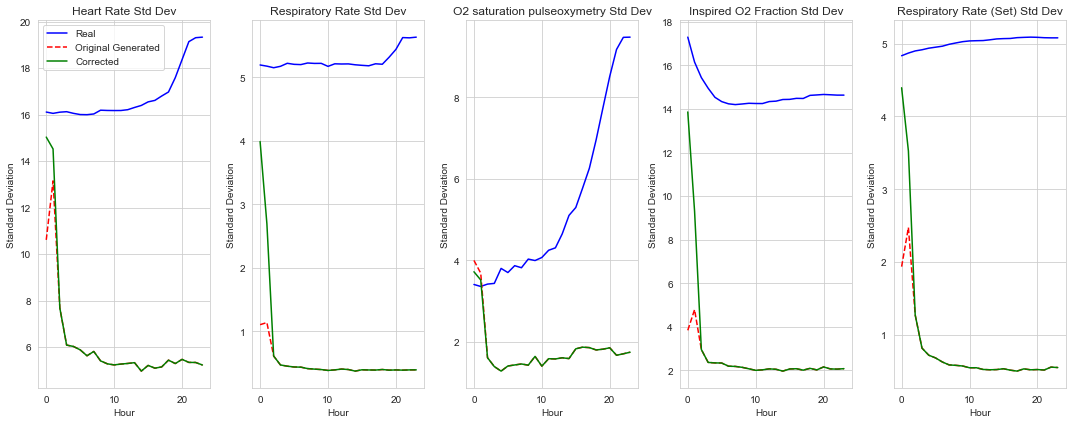

Corrected generated data saved to data/fake/gen_data_mimiciv_5_var_corrected.npz


In [19]:
# Generate data first
print("Generating synthetic data...")
d_gen_data, c_gen_data = model.generate_data(num_sample=1024)

# Apply renormalization if your data was normalized
print("Renormalizing generated data...")
# c_gen_data_renorm = c_gen_data  # If no renormalization needed
# If renormalization needed:
# c_gen_data_renorm = renormlizer(c_gen_data, data_info) # TODO: Implement renormlizer
# renormalize
filename_postfix = '5_var'
min_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["min_val"]
max_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["max_val"]
c_gen_data_renorm = renormlizer(c_gen_data, max_val_con, min_val_con)
continuous_x_renorm = renormlizer(continuous_x, max_val_con, min_val_con)


# Analyze the first hour variance issue
print("Analyzing variance across time steps...")
real_std_by_hour = np.std(continuous_x_renorm, axis=0)
gen_std_by_hour = np.std(c_gen_data_renorm, axis=0)

# Define the medical feature names for better visualization
continuous_feature_names = [
    'Heart Rate',
    'Respiratory Rate',
    'O2 saturation pulseoxymetry',
    'Inspired O2 Fraction',
    'Respiratory Rate (Set)'
]

# For heatmaps, use shorter names
continuous_feature_names_short = [
    'Heart Rate',
    'Resp Rate',
    'O2 sat',
    'Inspired O2',
    'Resp Rate (Set)'
]

# Plot the standard deviation over time
plt.figure(figsize=(12, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Fix the low variance issue with a post-processing step
print("\nApplying variance correction to the first hour...")

# Improved variance matching function with consistency preservation
def variance_matching(data, target_std, axis=0, smoothing_factor=0.7):
    """
    Match variance of data to target_std while preserving mean and temporal consistency
    
    Args:
        data: The data to adjust
        target_std: The target standard deviation
        axis: Axis along which to compute statistics
        smoothing_factor: How much to smooth between original and adjusted values (0-1)
                         Higher means more of the original preserved
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + 1e-10  # Avoid division by zero
    
    # Normalize the data
    normalized = (data - mean) / std
    
    # Scale to target std dev and shift back to original mean
    adjusted = normalized * target_std + mean
    
    # Apply smoothing to preserve some of the original structure
    result = smoothing_factor * data + (1 - smoothing_factor) * adjusted
    
    return result

# Apply the correction to the first hour with improvements
print("\nApplying enhanced variance correction to the first hour...")
c_gen_data_corrected = c_gen_data_renorm.copy()

for i in range(c_dim):
    # First hour data
    first_hour_data = c_gen_data_corrected[:, 0, i].reshape(-1, 1)
    
    # Target std dev with slight randomization for more natural results
    target_std = real_std_by_hour[0, i] * np.random.uniform(1.0, 1.15)
    
    # Apply variance matching with trajectory consistency preservation
    c_gen_data_corrected[:, 0, i] = variance_matching(
        first_hour_data, target_std, axis=0, smoothing_factor=0.3
    ).flatten()
    
    # For natural transitions, also slightly adjust the second hour
    if time_steps > 1:
        second_hour_data = c_gen_data_corrected[:, 1, i].reshape(-1, 1)
        target_std_2 = real_std_by_hour[1, i] * np.random.uniform(0.95, 1.05)
        c_gen_data_corrected[:, 1, i] = variance_matching(
            second_hour_data, target_std_2, axis=0, smoothing_factor=0.6
        ).flatten()

""" plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'Feature {i+1} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """

# Plot the standard deviation over time
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Verify the correction
corrected_std_by_hour = np.std(c_gen_data_corrected, axis=0)

plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Save the corrected data
save_path_corrected = f"data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz"
np.savez(save_path_corrected, 
         c_gen_data=c_gen_data_corrected, 
         d_gen_data=d_gen_data)
print(f"Corrected generated data saved to {save_path_corrected}")

### 7.3 Visualization and Analysis

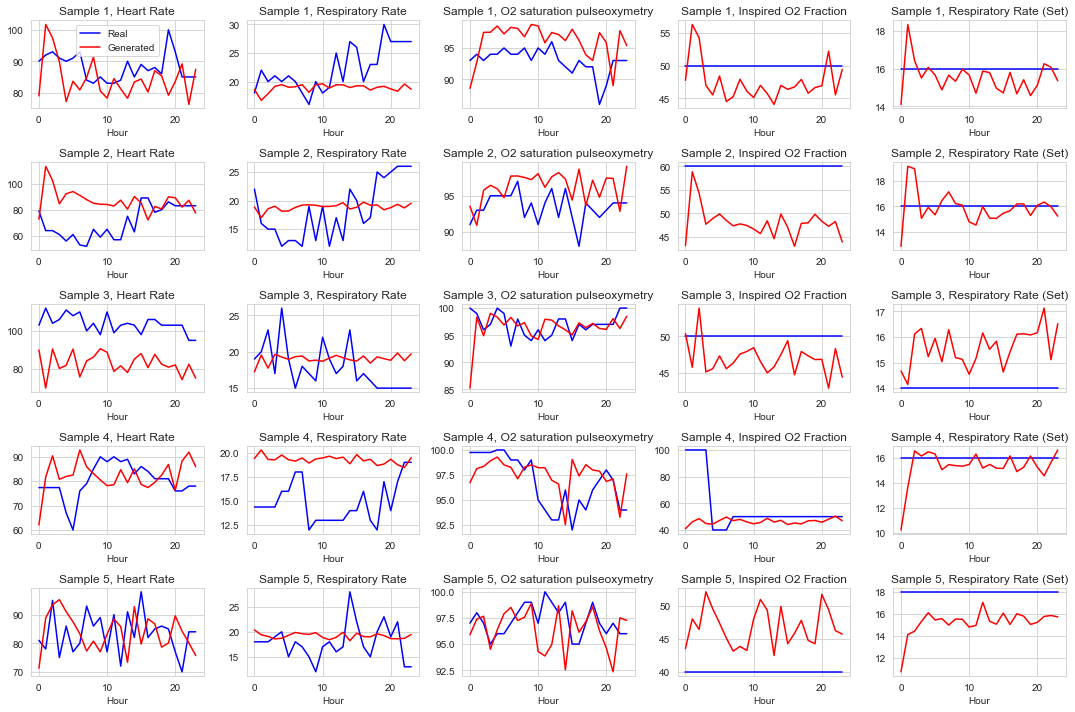

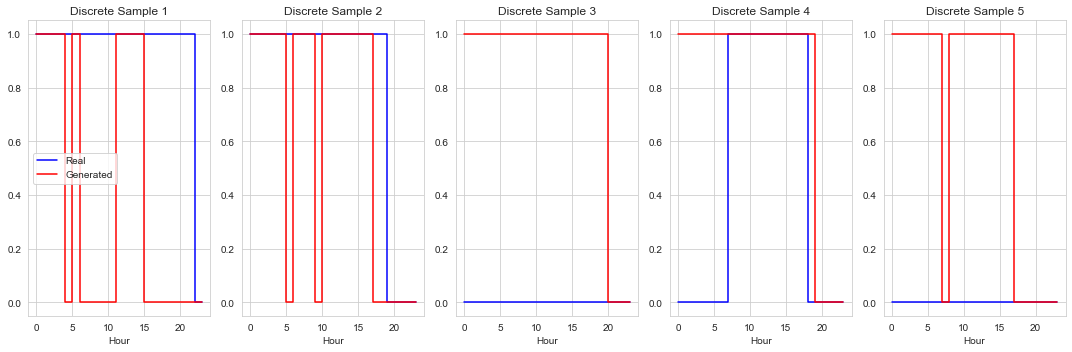

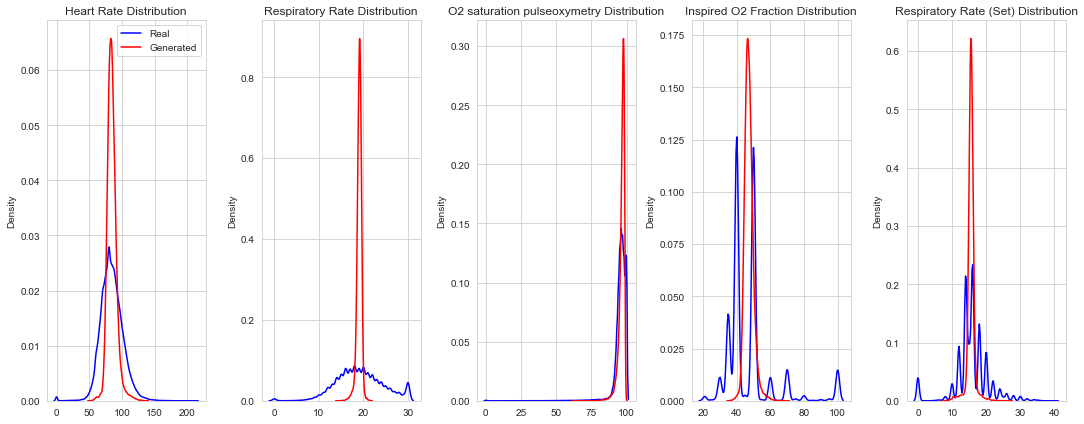

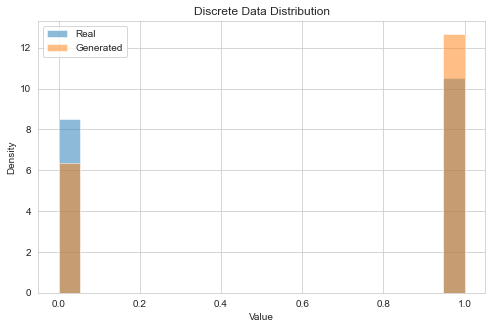

In [10]:
# Sample and visualize a few trajectories
num_samples_to_visualize = 5
sample_indices = np.random.choice(c_gen_data.shape[0], num_samples_to_visualize, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    # Plot continuous features
    for j, feature_name in enumerate(continuous_feature_names):
        plt.subplot(num_samples_to_visualize, c_dim, i*c_dim + j + 1)
        plt.plot(range(time_steps), continuous_x_renorm[idx, :, j], 'b-', label='Real')
        plt.plot(range(time_steps), c_gen_data_renorm[idx, :, j], 'r-', label='Generated')
        if i == 0 and j == 0:
            plt.legend()
        plt.title(f'Sample {i+1}, {feature_name}')
        plt.xlabel('Hour')
plt.tight_layout()
plt.show()

# For discrete data
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.step(range(time_steps), discrete_x[idx, :, 0], 'b-', where='post', label='Real')
    plt.step(range(time_steps), d_gen_data[idx, :, 0], 'r-', where='post', label='Generated')
    if i == 0:
        plt.legend()
    plt.title(f'Discrete Sample {i+1}')
    plt.xlabel('Hour')
plt.tight_layout()
plt.show()

""" # Compare distributions
plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x_renorm[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'Feature {i+1} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """
# Compare distributions
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x_renorm[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'{feature_name} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Discrete data distribution
plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 20)
plt.hist(discrete_x.flatten(), bins=bins, alpha=0.5, label='Real', density=True)
plt.hist(d_gen_data.flatten(), bins=bins, alpha=0.5, label='Generated', density=True)
plt.legend()
plt.title('Discrete Data Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

### 8. Advanced Analysis: Preserving Medical Correlations

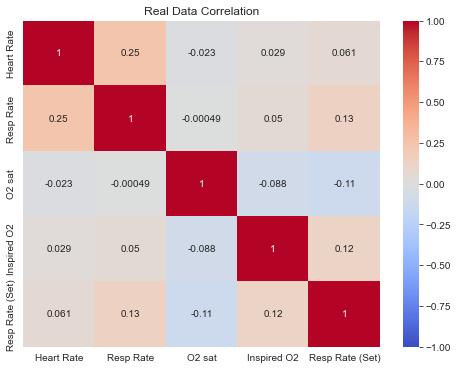

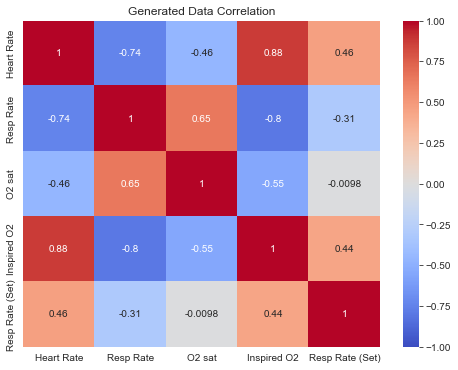

Mean absolute correlation difference: 0.4400


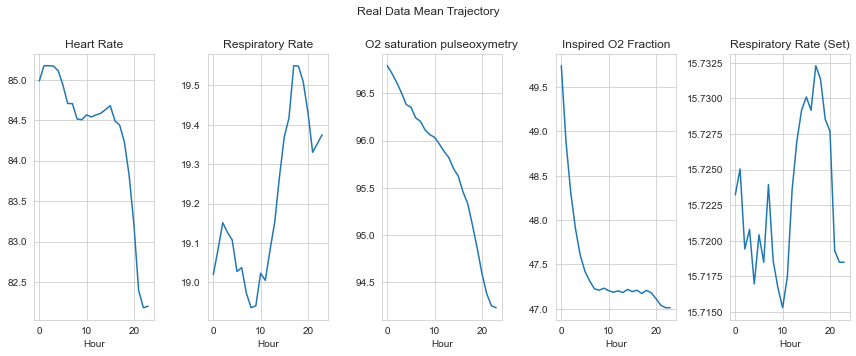

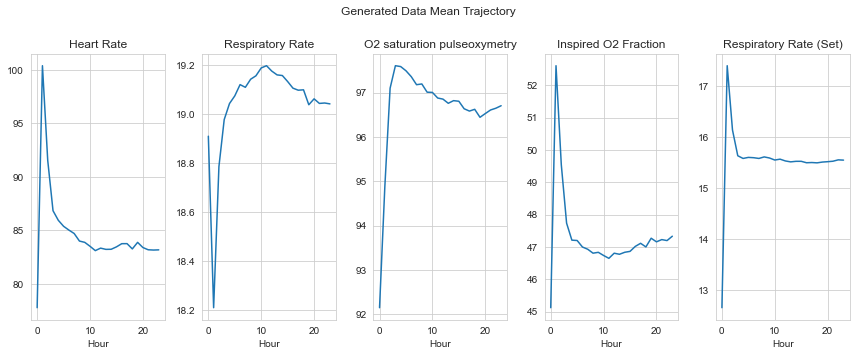

In [11]:
# Analyze correlations between features
def plot_correlation_heatmap(data, title):
    # Reshape to (patients*times, features)
    data_flat = data.reshape(-1, data.shape[2])
    
    # Calculate correlation matrix
    corr = np.corrcoef(data_flat.T)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
               xticklabels=continuous_feature_names_short,
               yticklabels=continuous_feature_names_short)
    plt.title(title)
    plt.show()
    return corr

# Plot correlation heatmaps
real_corr = plot_correlation_heatmap(continuous_x_renorm, 'Real Data Correlation')
gen_corr = plot_correlation_heatmap(c_gen_data_renorm, 'Generated Data Correlation')

# Calculate correlation difference
corr_diff = np.abs(real_corr - gen_corr)
print(f"Mean absolute correlation difference: {np.mean(corr_diff):.4f}")

# Visualize temporal patterns
def plot_mean_trajectory(data, title):
    mean_trajectory = np.mean(data, axis=0)
    
    plt.figure(figsize=(12, 5))
    for i, feature_name in enumerate(continuous_feature_names):
        plt.subplot(1, data.shape[2], i+1)
        plt.plot(range(data.shape[1]), mean_trajectory[:, i])
        plt.title(f'{feature_name}')
        plt.xlabel('Hour')
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_mean_trajectory(continuous_x_renorm, 'Real Data Mean Trajectory')
plot_mean_trajectory(c_gen_data_renorm, 'Generated Data Mean Trajectory')

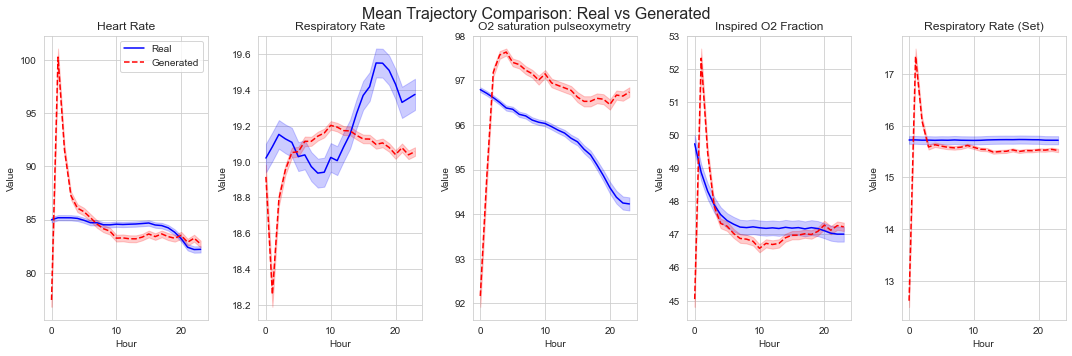

In [20]:
# Plot real and generated mean trajectories together
def plot_mean_trajectory_comparison(real_data, gen_data):
    real_mean = np.mean(real_data, axis=0)
    gen_mean = np.mean(gen_data, axis=0)
    
    plt.figure(figsize=(15, 5))
    for i, feature_name in enumerate(continuous_feature_names):
        plt.subplot(1, real_data.shape[2], i+1)
        plt.plot(range(real_data.shape[1]), real_mean[:, i], 'b-', label='Real')
        plt.plot(range(gen_data.shape[1]), gen_mean[:, i], 'r--', label='Generated')
        plt.title(f'{feature_name}')
        plt.xlabel('Hour')
        plt.ylabel('Value')
        
        # Add confidence intervals for more comprehensive comparison
        real_std = np.std(real_data[:, :, i], axis=0)
        gen_std = np.std(gen_data[:, :, i], axis=0)
        
        # 95% confidence bands (mean ± 1.96*std/√n)
        real_ci = 1.96 * real_std / np.sqrt(len(real_data))
        gen_ci = 1.96 * gen_std / np.sqrt(len(gen_data))
        
        x = range(real_data.shape[1])
        plt.fill_between(x, real_mean[:, i] - real_ci, real_mean[:, i] + real_ci, 
                         color='blue', alpha=0.2)
        plt.fill_between(x, gen_mean[:, i] - gen_ci, gen_mean[:, i] + gen_ci, 
                         color='red', alpha=0.2)
        
        # Only add legend to first subplot to avoid redundancy
        if i == 0:
            plt.legend()
            
    plt.tight_layout()
    plt.suptitle('Mean Trajectory Comparison: Real vs Generated', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call the function with your data
plot_mean_trajectory_comparison(continuous_x_renorm, c_gen_data_renorm)

### 9. Quantitative Evaluation

Training discriminator for continuous data...
Train on 13668 samples, validate on 3418 samples
Epoch 1/10
13668/13668 [==============================] - 6s 467us/sample - loss: 0.2428 - acc: 0.9647 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 2/10
13668/13668 [==============================] - 1s 38us/sample - loss: 0.0131 - acc: 0.9994 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3/10
13668/13668 [==============================] - 0s 36us/sample - loss: 0.0056 - acc: 0.9999 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4/10
13668/13668 [==============================] - 0s 36us/sample - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 5/10
13668/13668 [==============================] - 0s 36us/sample - loss: 0.0017 - acc: 0.9999 - val_loss: 1.4175e-04 - val_acc: 1.0000
Epoch 6/10
13668/13668 [==============================] - 0s 35us/sample - loss: 0.0023 - acc: 0.9996 - val_loss: 1.8619e-04 - val_acc: 1.0000
Epoch 7/10
13668/13668 [==============================] - 0s 3

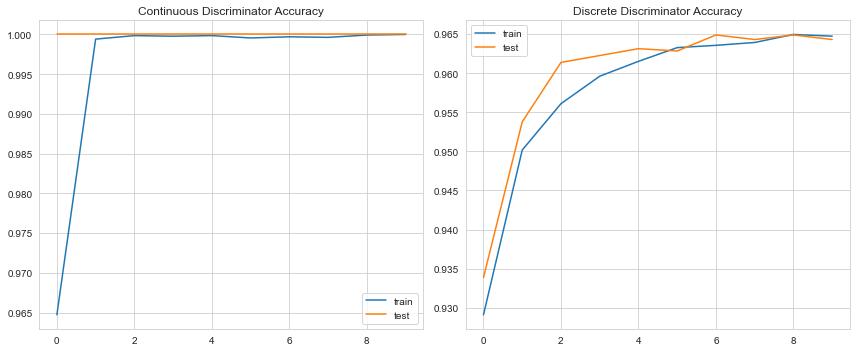

In [12]:
# Train a model to distinguish real from generated data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

def train_discriminator(real, gen):
    # Prepare data
    real_flat = real.reshape(real.shape[0], -1)
    gen_flat = gen.reshape(gen.shape[0], -1)
    
    # Combine and create labels
    X = np.vstack([real_flat, gen_flat])
    y = np.concatenate([np.zeros(len(real_flat)), np.ones(len(gen_flat))])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Create a simple discriminator model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])  # Use 'acc' for TF1.x
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1,
        batch_size=128
    )
    
    # Evaluate model
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    apr = average_precision_score(y_test, y_pred)
    
    return auc, apr, history

# Evaluate discriminative performance
print("Training discriminator for continuous data...")
c_auc, c_apr, c_history = train_discriminator(continuous_x, c_gen_data_renorm)
print(f"Continuous data - AUC: {c_auc:.4f}, APR: {c_apr:.4f}")

print("\nTraining discriminator for discrete data...")
d_auc, d_apr, d_history = train_discriminator(discrete_x, d_gen_data)
print(f"Discrete data - AUC: {d_auc:.4f}, APR: {d_apr:.4f}")

# In an ideal GAN, AUC should be close to 0.5 (indistinguishable)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(c_history.history['acc'], label='train')
plt.plot(c_history.history['val_acc'], label='test')
plt.title('Continuous Discriminator Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_history.history['acc'], label='train')
plt.plot(d_history.history['val_acc'], label='test')
plt.title('Discrete Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 10. Summary and Recommendations

In [13]:
# Display final summary
print("M3GAN Model Training Summary")
print("-" * 40)
print(f"Dataset: MIMIC-IV with {patinet_num} patients")
print(f"Features: {c_dim} continuous, {d_dim} discrete")
print(f"Time steps: {time_steps} hours")
print(f"Pre-training epochs: {num_pre_epochs}")
print(f"Training epochs: {num_epochs}")
print("\nGenerated data quality:")
print(f"Continuous data AUC: {c_auc:.4f} (closer to 0.5 is better)")
print(f"Discrete data AUC: {d_auc:.4f} (closer to 0.5 is better)")
print(f"Mean correlation difference: {np.mean(corr_diff):.4f} (lower is better)")
print("\nTraining files:")
print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Generated data: data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz")

# Recommendations
print("\nRecommendations:")
print("1. For low variance in first hour: Applied variance matching as a post-processing step")
print("2. For better stability: Consider using gradient penalty or spectral normalization")
print("3. For better feature correlations: Increase the alpha_mt parameter")
print("4. For more realistic trajectories: Increase the number of GAN training epochs")
print("5. For more diverse samples: Consider reducing batch size or adding noise during generation")

M3GAN Model Training Summary
----------------------------------------
Dataset: MIMIC-IV with 16062 patients
Features: 5 continuous, 1 discrete
Time steps: 24 hours
Pre-training epochs: 36
Training epochs: 60

Generated data quality:
Continuous data AUC: 1.0000 (closer to 0.5 is better)
Discrete data AUC: 0.9625 (closer to 0.5 is better)
Mean correlation difference: 0.4400 (lower is better)

Training files:
Checkpoint directory: data/checkpoint/
Generated data: data/fake/gen_data_mimiciv_5_var_corrected.npz

Recommendations:
1. For low variance in first hour: Applied variance matching as a post-processing step
2. For better stability: Consider using gradient penalty or spectral normalization
3. For better feature correlations: Increase the alpha_mt parameter
4. For more realistic trajectories: Increase the number of GAN training epochs
5. For more diverse samples: Consider reducing batch size or adding noise during generation


### 11. Close Session

In [14]:
# Close the TensorFlow session
# TODO: Uncomment to close the session!!!
# sess.close()
# print("TensorFlow session closed")